In [1]:
!pip install geopandas pandas numpy matplotlib seaborn statsmodels pygam scikit-learn shapely fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from statsmodels.api import GLM
from statsmodels.genmod.families import Binomial
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split
import fiona
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # If you want to try Random Forest
from sklearn.model_selection import train_test_split

In [3]:
train = gpd.read_file("/content/drive/MyDrive/A_LSM_DATA_FOR_PY/train.gpkg")

In [4]:
test = gpd.read_file("/content/drive/MyDrive/A_LSM_DATA_FOR_PY/test.gpkg")

In [5]:
train.head(2)

,YEAR,top,avg_rainfa,avg_ndvi,left,bottom,mean_slope,risk,right,id,geometry
0,2019,2.184984e+06,16.696393,0.015332,-379776.937229,2.174984e+06,0.046270,0,-368229.931846,813,"MULTIPOLYGON (((72.7168 19.54542, 72.71848 19...."
1,2019,2.174984e+06,17.090555,-0.015152,-379776.937229,2.164984e+06,0.030738,0,-368229.931846,814,"MULTIPOLYGON (((72.72625 19.46764, 72.72708 19..."


In [6]:
print(f"Shape: {train.shape}")
print("Sample row:\n", train.sample(1).T)
print(f"Columns: {train.columns.tolist()}\n")

Shape: (2590, 11)
Sample row:
                                                           419
YEAR                                                     2019
top                                            2099983.509522
avg_rainfa                                           3.471867
avg_ndvi                                               0.0426
left                                           -232552.618586
bottom                                         2089983.509522
mean_slope                                           0.335357
risk                                                        0
right                                          -221005.613202
id                                                       3491
geometry    MULTIPOLYGON (((74.06097346412913 18.817418319...
Columns: ['YEAR', 'top', 'avg_rainfa', 'avg_ndvi', 'left', 'bottom', 'mean_slope', 'risk', 'right', 'id', 'geometry']



In [7]:
print(f"Layers:")
try:    # list all the layers in train.gpkg
    layers = fiona.listlayers(train)
    for layer in layers:
        print(f" - {layer}")
except Exception as e:
    print(f"Could not read layers from {train}: {e}")

Layers:
Could not read layers from       YEAR           top  avg_rainfa  avg_ndvi           left        bottom  \
0     2019  2.184984e+06   16.696393  0.015332 -379776.937229  2.174984e+06   
1     2019  2.174984e+06   17.090555 -0.015152 -379776.937229  2.164984e+06   
2     2019  2.209984e+06   16.401742  0.033570 -371116.683191  2.199984e+06   
3     2019  2.199984e+06   16.390867  0.035961 -371116.683191  2.189984e+06   
4     2019  2.169984e+06   17.529161  0.024382 -371116.683191  2.159984e+06   
...    ...           ...         ...       ...            ...           ...   
2585  2020  9.949835e+05    8.957341  0.113073   87876.780814  9.849835e+05   
2586  2020  9.549835e+05    7.291428  0.072888   87876.780814  9.449835e+05   
2587  2020  1.049984e+06    8.860948  0.115770   96537.034852  1.039984e+06   
2588  2020  9.499835e+05    5.749314  0.074720   96537.034852  9.399835e+05   
2589  2020  9.549835e+05    4.959613  0.116520  105197.288890  9.449835e+05   

      mean_slope

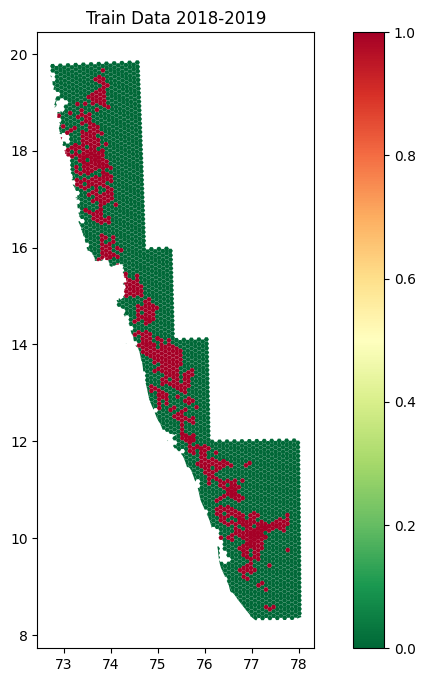

In [8]:
# VISUALIZATION OF TRAINING DATA MAP
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

train.plot(column='risk', cmap='RdYlGn_r', legend=True, ax=ax)
plt.title('Train Data 2018-2019')
plt.show()

In [9]:
train.columns

Index(['YEAR', 'top', 'avg_rainfa', 'avg_ndvi', 'left', 'bottom', 'mean_slope',
       'risk', 'right', 'id', 'geometry'],
      dtype='object')

In [10]:
data = train[['avg_rainfa', 'avg_ndvi', 'mean_slope', 'risk']]

In [11]:
data.describe()

,avg_rainfa,avg_ndvi,mean_slope,risk
count,2590.000000,2590.000000,2590.000000,2590.000000
mean,11.305956,0.081658,1.137784,0.244788
std,8.192578,0.042417,1.361671,0.430044
min,0.000000,-0.030547,0.000000,0.000000
25%,3.970491,0.049618,0.294527,0.000000
50%,8.866621,0.077531,0.550508,0.000000
75%,18.137707,0.105804,1.426286,0.000000
max,34.778895,0.369358,9.688341,1.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   avg_rainfa  2590 non-null   float64
 1   avg_ndvi    2590 non-null   float64
 2   mean_slope  2590 non-null   float64
 3   risk        2590 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 70.9 KB


In [13]:
data.corr()

,avg_rainfa,avg_ndvi,mean_slope,risk
avg_rainfa,1.000000,-0.336328,0.015366,0.313293
avg_ndvi,-0.336328,1.000000,-0.040563,-0.206681
mean_slope,0.015366,-0.040563,1.000000,0.337668
risk,0.313293,-0.206681,0.337668,1.000000


<Axes: >

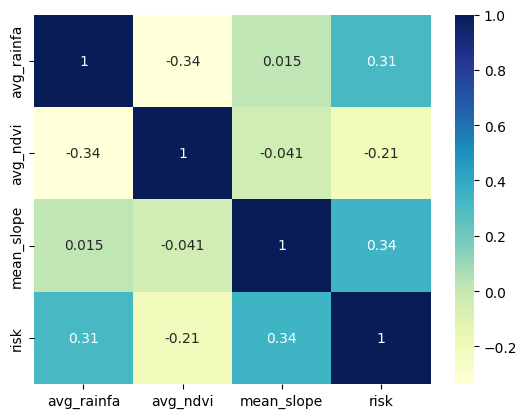

In [14]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [15]:
data['risk'].value_counts()

,count
risk,
0,1956
1,634


In [16]:
train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   YEAR        2590 non-null   object  
 1   top         2590 non-null   float64 
 2   avg_rainfa  2590 non-null   float64 
 3   avg_ndvi    2590 non-null   float64 
 4   left        2590 non-null   float64 
 5   bottom      2590 non-null   float64 
 6   mean_slope  2590 non-null   float64 
 7   risk        2590 non-null   int32   
 8   right       2590 non-null   float64 
 9   id          2590 non-null   int32   
 10  geometry    2590 non-null   geometry
dtypes: float64(7), geometry(1), int32(2), object(1)
memory usage: 202.5+ KB


In [17]:
train.describe()

,top,avg_rainfa,avg_ndvi,left,bottom,mean_slope,risk,right,id
count,2.590000e+03,2590.000000,2590.000000,2590.000000,2.590000e+03,2590.000000,2590.000000,2590.000000,2590.000000
mean,1.551447e+06,11.305956,0.081658,-102347.872550,1.541447e+06,1.137784,0.244788,-90800.867166,5906.064093
std,3.825293e+05,8.192578,0.042417,151636.579230,3.825293e+05,1.361671,0.430044,151636.579230,2783.777699
min,9.299835e+05,0.000000,-0.030547,-379776.937229,9.199835e+05,0.000000,0.000000,-368229.931846,813.000000
25%,1.214984e+06,3.970491,0.049618,-223892.364548,1.204984e+06,0.294527,0.000000,-212345.359164,3637.250000
50%,1.509984e+06,8.866621,0.077531,-128629.570132,1.499984e+06,0.550508,0.000000,-117082.564748,5440.500000
75%,1.904984e+06,18.137707,0.105804,35915.256587,1.894984e+06,1.426286,0.000000,47462.261971,8459.750000
max,2.209984e+06,34.778895,0.369358,165819.067155,2.199984e+06,9.688341,1.000000,177366.072539,10830.000000


In [18]:
train['risk'] = pd.to_numeric(train['risk'], errors='coerce')

In [19]:
train["risk"].value_counts()

,count
risk,
0,1956
1,634


In [20]:
X = train[['avg_rainfa', 'mean_slope', 'avg_ndvi']]
y = train['risk']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
kerala_2024 = test[['avg_rainfa', 'mean_slope', 'avg_ndvi']]

# DENSE NEURAL NETWORK

In [23]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
data.columns

Index(['avg_rainfa', 'avg_ndvi', 'mean_slope', 'risk'], dtype='object')

In [26]:
X = data[['avg_rainfa', 'avg_ndvi', 'mean_slope']].values
y = data['risk'].map({0: 0, 1: 1}).values  # Ensure risk is 0/1
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# FINAL BOSS

import tensorflow as tf
from sklearn.metrics import f1_score, precision_recall_curve

# Metrics
metrics = [
    tf.keras.metrics.AUC(name="AUC"),
    tf.keras.metrics.Precision(name="Precision"),
    tf.keras.metrics.Recall(name="Recall"),
    tf.keras.metrics.AUC(name="roc_auc"),  # ROC AUC
]

# Custom F1-score metric (since Keras does not have F1-score by default)
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to 0 or 1
    return tf.py_function(f1_score, (y_true, y_pred), tf.float32)

# Focal Loss definition
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        fl = alpha * tf.pow(1 - p_t, gamma) * bce
        return tf.reduce_mean(fl)
    return loss

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_AUC",
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Define model architecture
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=metrics
)

# Train the model
history = model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)
import pandas as pd

# Extract metrics from the history object
# history_df = pd.DataFrame(history.history)

# Save the metrics to a CSV file
# history_df.to_csv('history_DNN.csv', index=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.6213 - Precision: 0.2713 - Recall: 0.1646 - loss: 0.0307 - roc_auc: 0.6213 - val_AUC: 0.8413 - val_Precision: 0.6970 - val_Recall: 0.2018 - val_loss: 0.0173 - val_roc_auc: 0.8413 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8305 - Precision: 0.5375 - Recall: 0.2084 - loss: 0.0160 - roc_auc: 0.8305 - val_AUC: 0.8451 - val_Precision: 0.5763 - val_Recall: 0.2982 - val_loss: 0.0156 - val_roc_auc: 0.8451 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8489 - Precision: 0.6430 - Recall: 0.3325 - loss: 0.0140 - roc_auc: 0.8489 - val_AUC: 0.8454 - val_Precision: 0.6133 - val_Recall: 0.4035 - val_loss: 0.0149 - val_roc_auc: 0.8454 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8314 - Precision: 0.5531 - Recall: 0.3706 - loss: 0.0143 - roc_auc: 0.8314 - val_AUC: 0.8481 - val_Precision: 0.5897 - val_Recall: 0.4035 - val_loss: 0.0

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
import numpy as np
X_test1 = X_test
y_test1 = y_test
# Predict on the test set
y_pred = model2.predict(X_test1)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert to binary (0 or 1)

# Calculate AUC (Area Under ROC Curve)
auc = roc_auc_score(y_test1, y_pred)

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary)

# Calculate Precision
precision = precision_score(y_test1, y_pred_binary)

# Calculate Recall
recall = recall_score(y_test1, y_pred_binary)

# Calculate F1-score
f1 = f1_score(y_test1, y_pred_binary)

# Optionally, plot Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test1, y_pred)

# Print all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7664
Precision: 0.5268
Recall: 0.4646
F1-score: 0.4937
AUC: 0.8549


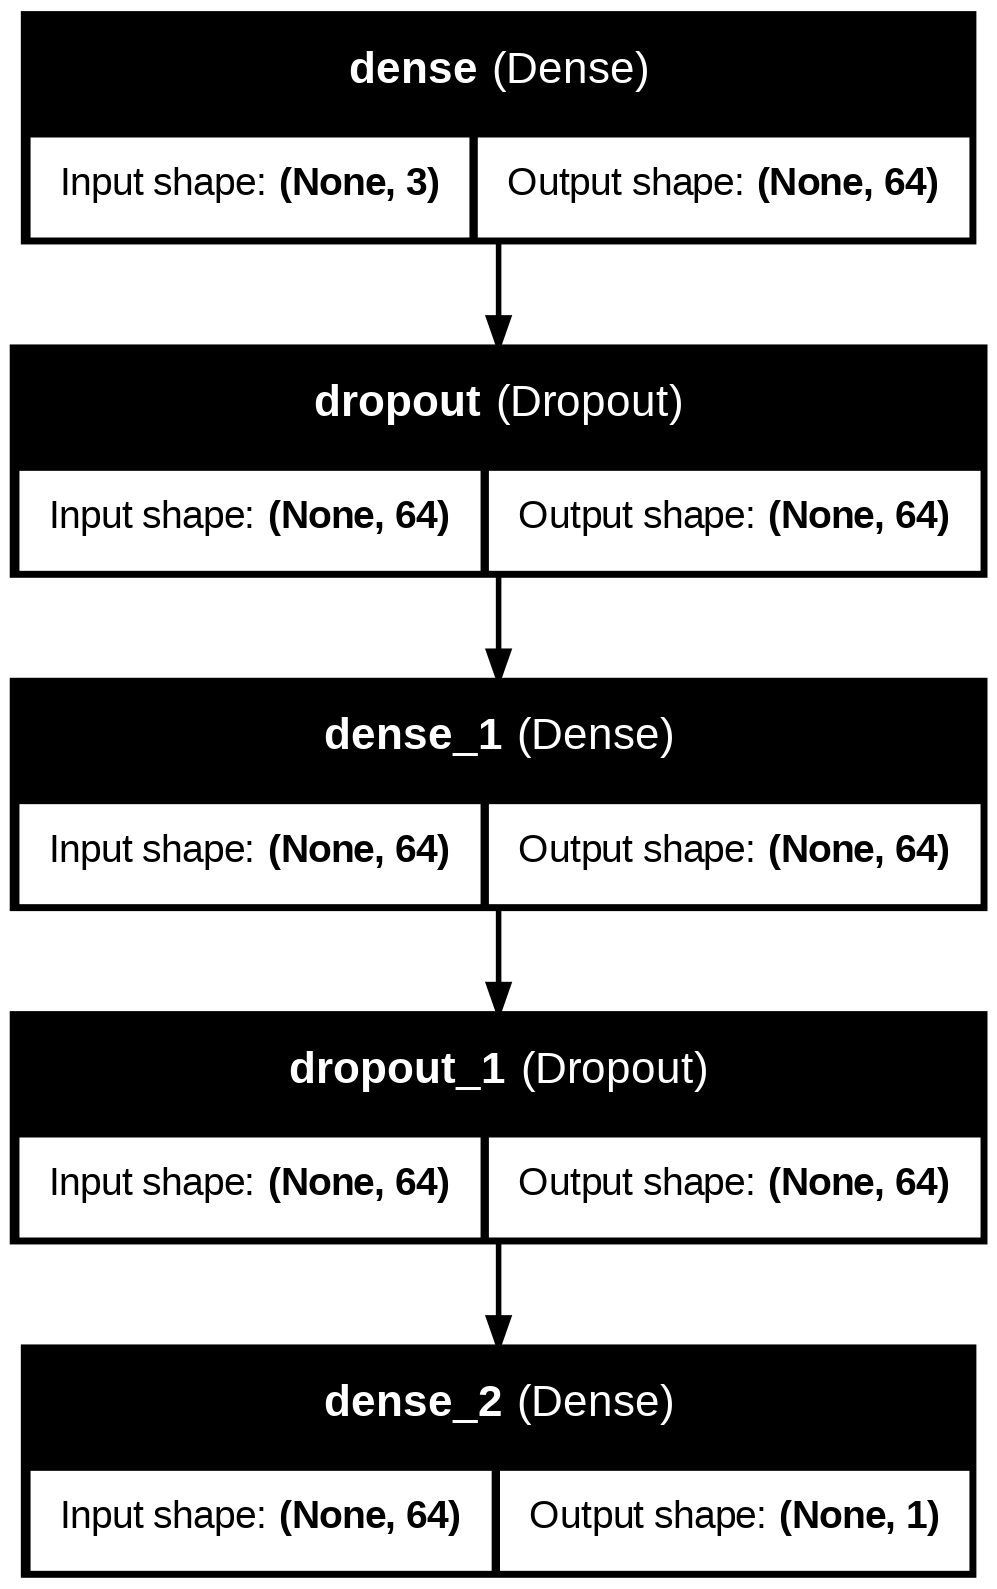

In [29]:
from tensorflow.keras.utils import plot_model

# Save a diagram of the model
plot_model(
    model2,
    to_file='model_diagram.png',
    show_shapes=True,  # Display input/output shapes
    show_layer_names=True  # Display layer names
)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8578 - Precision: 0.5260 - Recall: 0.4447 - loss: 0.0132 - roc_auc: 0.8578 
Evaluation Results:
loss: 0.0128
compile_metrics: 0.8547
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
102/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


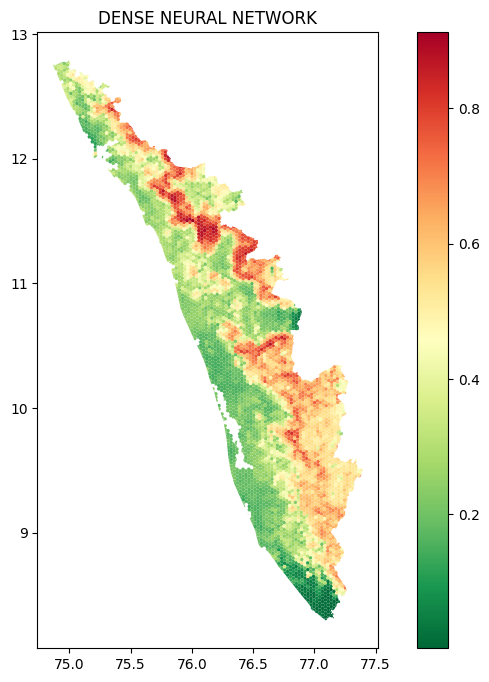

In [30]:
# FINAL BOSS

# Evaluate the model
evaluation_results = model2.evaluate(X_test, y_test)
print("Evaluation Results:")
for metric, value in zip(model2.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

# Predict probabilities for landslide risk

# Reshape and scale test data
# X_test1 = X_test1.values.reshape(-1, 1)  # Reshape to 2D
X_test1 = scaler.transform(X_test1)

# Convert back to DataFrame (if needed)
# X_test1 = pd.DataFrame(X_test1, columns=['avg_rainfall'])

y_pred = model2.predict(X_test1)

ker1 = test[['avg_rainfa', 'avg_ndvi', 'mean_slope']]
# Reshape and scale test data
# ker1 = ker1.values.reshape(-1, 1)  # Reshape to 2D
ker1 = scaler.transform(ker1)

# Convert back to DataFrame (if needed)
# ker1 = pd.DataFrame(ker1, columns=['avg_rainfall'])

test['risk1'] = model2.predict(ker1).flatten()
# Plot predictions on the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
test.plot(column='risk1', cmap='RdYlGn_r', legend=True, ax=ax)
plt.title('DENSE NEURAL NETWORK')
plt.show()

In [31]:
waya = "/content/drive/MyDrive/A_LSM_DATA_FOR_PY/wayanad.gpkg"

In [32]:
waya = gpd.read_file(waya)

In [33]:
waya

,GID_2,NAME_2,geometry
0,8,Wayanad,"MULTIPOLYGON (((-23595.486 1288637.834, -18653..."
1,1,Wayanad,"MULTIPOLYGON (((-53627.06 1314837.595, -44241...."
2,2,Wayanad,"MULTIPOLYGON (((-44241.977 1306639.983, -34455..."
3,3,Wayanad,"MULTIPOLYGON (((-34455.853 1298101.79, -23595...."
4,4,Wayanad,"MULTIPOLYGON (((-44241.977 1306639.983, -53627..."
5,5,Wayanad,"MULTIPOLYGON (((-34455.853 1298101.79, -44241...."
6,6,Wayanad,"MULTIPOLYGON (((-23595.486 1288637.834, -34455..."
7,7,Wayanad,"MULTIPOLYGON (((-18653.741 1284335.458, -23595..."


In [34]:
waya.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GID_2     8 non-null      object  
 1   NAME_2    8 non-null      object  
 2   geometry  8 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 324.0+ bytes


In [35]:
waya['GID_2'] = pd.to_numeric(waya['GID_2'], errors='coerce')

In [36]:
# dec 20 predictions
rf_20_12 = {
    1: 23.89,
    2: 24.10,
    3: 23.55,
    4: 20.34,
    5: 19.87,
    6: 16.09,
    7: 15.45,
    8: 23.08
}

slope = {
    1: 2.9220,
    2: 0.54605,
    3: 2.6696,
    4: 1.96742,
    5: 0.23466,
    6: 0.047459,
    7: 0.29721,
    8: 2.71989
}
ndvi = {
    1: 0.04005,
    2: 0.05943,
    3: 0.06249,
    4: 0.051388,
    5: 0.08721,
    6: 0.09459,
    7: 0.077201,
    8: 0.08345
}

In [37]:
waya['avg_rainfa'] = waya['GID_2'].map(rf_20_12)
waya['avg_ndvi'] = waya['GID_2'].map(ndvi)
waya['mean_slope'] = waya['GID_2'].map(slope)

In [38]:
waya

,GID_2,NAME_2,geometry,avg_rainfa,avg_ndvi,mean_slope
0,8,Wayanad,"MULTIPOLYGON (((-23595.486 1288637.834, -18653...",23.08,0.083450,2.719890
1,1,Wayanad,"MULTIPOLYGON (((-53627.06 1314837.595, -44241....",23.89,0.040050,2.922000
2,2,Wayanad,"MULTIPOLYGON (((-44241.977 1306639.983, -34455...",24.10,0.059430,0.546050
3,3,Wayanad,"MULTIPOLYGON (((-34455.853 1298101.79, -23595....",23.55,0.062490,2.669600
4,4,Wayanad,"MULTIPOLYGON (((-44241.977 1306639.983, -53627...",20.34,0.051388,1.967420
5,5,Wayanad,"MULTIPOLYGON (((-34455.853 1298101.79, -44241....",19.87,0.087210,0.234660
6,6,Wayanad,"MULTIPOLYGON (((-23595.486 1288637.834, -34455...",16.09,0.094590,0.047459
7,7,Wayanad,"MULTIPOLYGON (((-18653.741 1284335.458, -23595...",15.45,0.077201,0.297210


In [39]:
d20_12 = waya[['avg_rainfa','avg_ndvi','mean_slope']]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


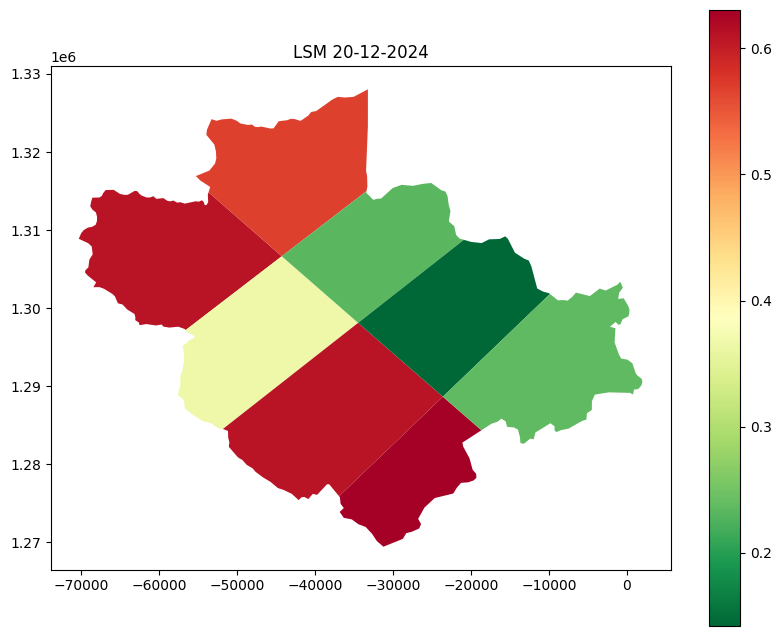

In [40]:
d20_12 = scaler.transform(d20_12)

# Convert back to DataFrame (if needed)
# ker1 = pd.DataFrame(ker1, columns=['avg_rainfall'])

waya['risk20_12'] = model2.predict(d20_12).flatten()
# Plot predictions on the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
waya.plot(column='risk20_12', cmap='RdYlGn_r', legend=True, ax=ax)
plt.title('LSM 20-12-2024')
plt.show()